In [21]:
import uproot
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from pathlib import Path

In [22]:
# new_mcfile_path = "/global/cfs/projectdirs/atlas/hrzhao/qgcal/Processed_Samples/dijet_pythia_mc16D.root"
# new_mcfile = uproot.open(new_mcfile_path)

# old_mcfile_path = "/global/cfs/projectdirs/atlas/hrzhao/qgcal/dijet-mono-result/pythia/dijet_pythia_mono-d.root"
# old_mcfile = uproot.open(old_mcfile_path)
# datafile_path = "/global/cfs/projectdirs/atlas/hrzhao/qgcal/Processed_Samples_Data/data17/dijet_data_17.root"
# datafile = uproot.open(datafile_path)



new_mcfile_path = "/global/cfs/projectdirs/atlas/hrzhao/qgcal/New_Codes/Validation/dijet_new_MC16D.root"
new_mcfile = uproot.open(new_mcfile_path)

old_mcfile_path = "/global/cfs/projectdirs/atlas/hrzhao/qgcal/New_Codes/Validation/dijet_old_MC16D.root"
old_mcfile = uproot.open(old_mcfile_path)

In [23]:
label_ptrange = [500, 600, 800, 1000, 1200, 1500, 2000]
label_leadingtype = ["LeadingJet", "SubJet"]
label_etaregion = ["Forward", "Central"]
label_jettype = ["Quark", "Gluon", "B_Quark", "C_Quark", "Other"]
label_var = ["pt", "eta", "ntrk", "width", "c1", "bdt"]
n_bins_var = [60, 50, 60, 60, 60, 60]


In [24]:
def Read_Histogram_by_JetType(file, code_version="new"):
    Read_HistMap = {}
    Read_HistMap_Error = {}

    if code_version=="new":
        file = file["NoReweighting"]

    available_keys = [*file.keys()]
    for i, jettype in enumerate(label_jettype):
        Read_HistMap[jettype] = np.zeros((n_bins_var[0]), dtype=float)
        Read_HistMap_Error[jettype] = np.zeros((n_bins_var[0]), dtype=float)
        for pt in label_ptrange[:-1]:
            for leadingtype in label_leadingtype[0:1]:
                for eta_region in label_etaregion: 
                    if not f"{pt}_{leadingtype}_{eta_region}_{jettype}_{label_var[0]};1" in available_keys:
                        continue 
                    Read_HistMap[jettype] += file[f"{pt}_{leadingtype}_{eta_region}_{jettype}_{label_var[0]}"].to_numpy()[0]
                    Read_HistMap_Error[jettype] += file[f"{pt}_{leadingtype}_{eta_region}_{jettype}_{label_var[0]}_err"].to_numpy()[0]

    return Read_HistMap, Read_HistMap_Error

def cal_sum(Read_HistMap):
    MC_jet_types = ['C_Quark', 'B_Quark', 'Gluon', 'Quark']
    MC_jets = []
    for MC_jet_type in MC_jet_types:
        MC_jets.append(Read_HistMap[MC_jet_type])

    MC_jets = np.array(MC_jets)
    cumsum_MC_jets = np.cumsum(MC_jets, axis = 0)
    return cumsum_MC_jets[-1], np.sum(MC_jets, axis = 1)

def plot_compare(new_Read_HistMap, old_Read_HistMap, jettype, period, slice, if_save=False, output_path=None):
    custom_bins = np.linspace(0, 2000, 61)
    pt_bin_centers = 1/2 * (custom_bins[:-1] + custom_bins[1:])
    fig, (ax, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})
    ax.fill_between(pt_bin_centers, 0, new_Read_HistMap, label=f"New Code, {jettype}, num:{np.sum(new_Read_HistMap):.2f}", step = 'mid')
    ax.scatter(pt_bin_centers, old_Read_HistMap, color= "black", marker= "o", label = f"Old Code, {jettype}, num:{np.sum(old_Read_HistMap):.2f}")

    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.true_divide(new_Read_HistMap, old_Read_HistMap)
        ratio[ratio == np.inf] = 0
        ratio = np.nan_to_num(ratio)

    ax1.stairs(values = ratio, edges=custom_bins, color = "black", linestyle=':', label = 'New / Old', baseline=None)
    ax1.hlines(y = 1, xmin = 500, xmax = 2000, color = 'gray', linestyle = '--')
    ax1.set_ylabel("Ratio")
    ax1.set_ylim(0.7, 1.3)
    ax1.set_xlabel('Jet $p_{\mathrm{T}}$ [GeV]')

    ax.set_yscale('log')
    ax.set_xlim(500, 2000)
    ax.set_title( f'MC16{period} {slice} ' + 'Leading Jet $p_{T}$ Spectrum Component')
    # ax.set_title( f'MC16A JZ8 ' + 'Leading Jet $p_{T}$ Spectrum Component')

    ax.set_ylabel('Number of Events')
    ax.legend()
    ax1.legend()

    # assert np.sum(ratio[ratio!=0]) == len(ratio[ratio!=0])
    is_passed = np.allclose(new_Read_HistMap,  old_Read_HistMap, rtol=1e-4)
    if is_passed:
        ax.annotate("Passed!", xy=(0, 1), xytext=(-15, -15), fontsize=10, color= 'red',
                    xycoords='axes fraction', textcoords='offset points',
                    bbox=dict(facecolor='white', alpha=0.8),
                    horizontalalignment='right', verticalalignment='top')

    if if_save == True:
        fig.savefig(output_path.as_posix() + "/" + f"pt_spectrum_compared_MC16{period}_JZ{slice}_{jettype}", dpi = 100)
    else:
        fig.show()

In [25]:
Read_HistMap_new, Read_HistMap_Error_new = Read_Histogram_by_JetType(new_mcfile, code_version='new')
Read_HistMap_old, Read_HistMap_Error_old = Read_Histogram_by_JetType(old_mcfile, code_version='old')

31702572.504356485 [  787603.24283907   448794.78663144 14504939.13037698 15961235.344509  ]
31750324.800059445 [  789051.40920524   449439.61639026 14529435.69028411 15982398.08417983]


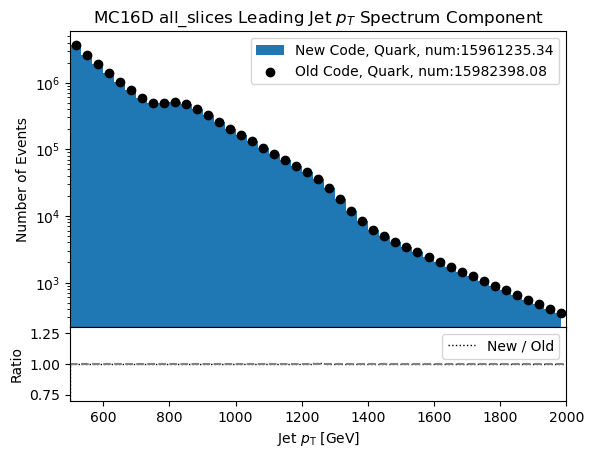

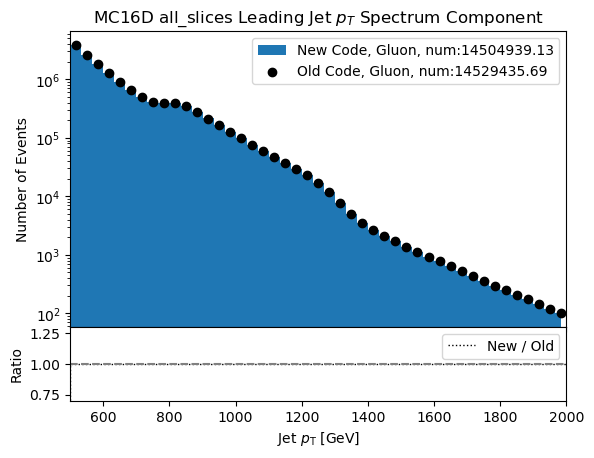

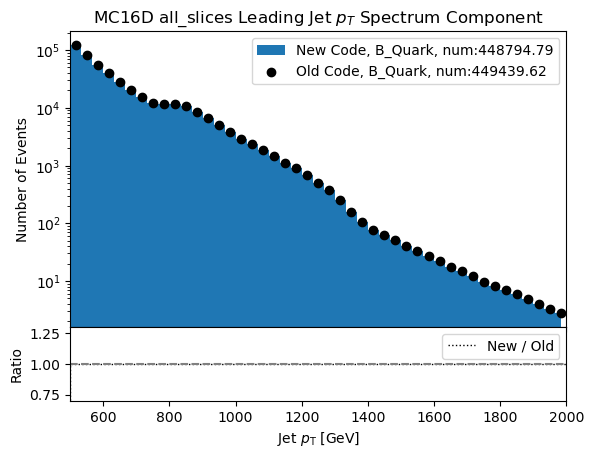

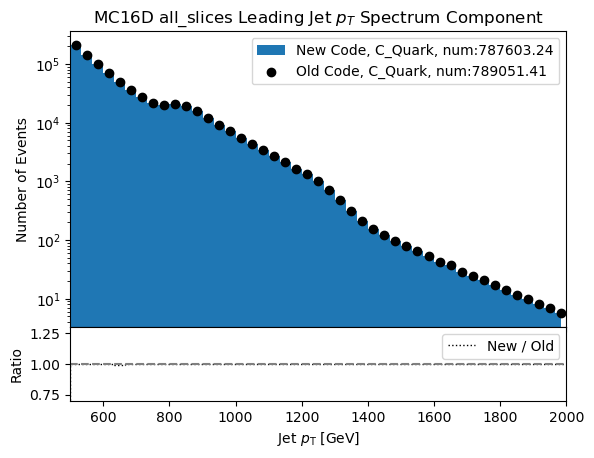

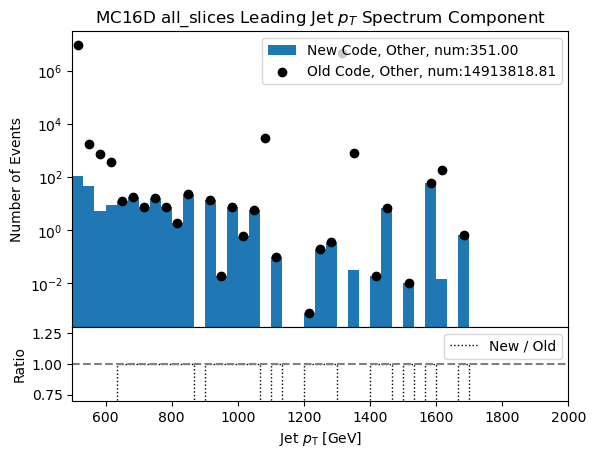

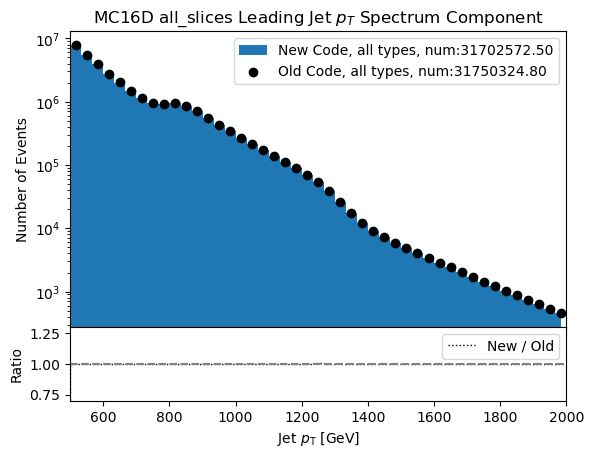

In [27]:
period = 'D'
slice = 'all_slices'
for i, jettype in enumerate(label_jettype):
    plot_compare(new_Read_HistMap=Read_HistMap_new[jettype], old_Read_HistMap=Read_HistMap_old[jettype], jettype=jettype, period=period, slice=slice, if_save=False)

sum_new, sum_MC_jets_new = cal_sum(Read_HistMap=Read_HistMap_new)
sum_old, sum_MC_jets_old = cal_sum(Read_HistMap=Read_HistMap_old)

plot_compare(new_Read_HistMap=sum_new, old_Read_HistMap=sum_old, jettype='all types', period= period, slice =slice, if_save=False)

print(np.sum(sum_new), sum_MC_jets_new)
print(np.sum(sum_old), sum_MC_jets_old)